In [1]:
import io, os, random
import base64
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2

import vertexai
from vertexai.generative_models import GenerativeModel, Part, FinishReason
import vertexai.preview.generative_models as generative_models

In [2]:
def generate(prompt):
  vertexai.init(project="turan-genai-bb", location="us-central1")
  model = GenerativeModel(
    "gemini-1.5-pro-001",
  )
  responses = model.generate_content(
      prompt,
      generation_config=generation_config,
      safety_settings=safety_settings,
      stream=True,
  )

  for response in responses:
    print(response.text, end="")


generation_config = {
    "max_output_tokens": 2048,
    "temperature": 0.7,
    "top_p": 1,
    "top_k": 32,
}

safety_settings = {
    generative_models.HarmCategory.HARM_CATEGORY_HATE_SPEECH: generative_models.HarmBlockThreshold.BLOCK_ONLY_HIGH,
    generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_ONLY_HIGH,
    generative_models.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: generative_models.HarmBlockThreshold.BLOCK_ONLY_HIGH,
    generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_ONLY_HIGH,
}

def get_example_images(row_id):
    # Define the images and their captions
    images =[
        (np.fromstring(dataset1.real_image[row_id]).reshape([100,100]), "Real Image"),
        (np.fromstring(dataset1.image_ref[row_id]).reshape([100,100]), "Reference Image"),
        (np.fromstring(dataset1.image_difference[row_id]).reshape([100,100]), "Difference Image"),
        (np.fromstring(dataset1.image_scorr[row_id]).reshape([100,100]), "Scorr Image")
    ] 
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2)

    # Iterate over the images and display them with captions
    for i, (image, caption) in enumerate(images):
        axs[i // 2, i % 2].imshow(image)
        axs[i // 2, i % 2].set_title(caption)

    # Remove the axes ticks and labels
    for ax in axs.flat:
        ax.set_xticks([])
        ax.set_yticks([])

    # Tight layout and display the plot
    plt.tight_layout()
    plt.show()

def encode_string(data):
    np_array = np.fromstring(base64.b64decode(base64.b64encode(data.encode("ascii")))).reshape([100,100])
    scaled_array = np_array * 255 / np.max(np_array)
    success, encoded_image =  cv2.imencode('.png', scaled_array)
    content = encoded_image.tobytes()
    return content

def create_ex(data_index):   
    str_new = "new image: "
    str_ref = "reference image: "
    str_dif = "difference image: "
    str_sco = "Scorr image: "
    str_lab = "label: "
    
    image1 = Part.from_data(mime_type="image/png", data=encode_string(dataset1.real_image[data_index]))
    image2 = Part.from_data(mime_type="image/png", data=encode_string(dataset1.image_ref[data_index]))
    image3 = Part.from_data(mime_type="image/png", data=encode_string(dataset1.image_difference[data_index]))
    image4 = Part.from_data(mime_type="image/png", data=encode_string(dataset1.image_scorr[data_index]))
    return [str_new, image1, str_ref, image2, str_dif, image3, str_sco, image4, str_lab]

In [3]:
# Read data
#! wget -O threshold_9_training_set.csv https://zenodo.org/records/7758673/files/threshold_9_testing_set.csv?download=1
dataset1 = pd.read_csv("threshold_9_training_set.csv")
# Replace the label names
dataset1['label'] = dataset1['label'].replace({1: 'Real', 0: 'Bogus'})

In [4]:
random.seed(42)
#Get 3 random examples from Real and Bogus
# Filter rows with label 'Real' and 'Bogus'
real_rows = dataset1[dataset1['label'] == 'Real']
bogus_rows = dataset1[dataset1['label'] == 'Bogus']

# Sample 3 rows from 'Real' and 2 rows from 'Bogus'
real_sample = random.sample(list(real_rows.index), 3)
bogus_sample = random.sample(list(bogus_rows.index), 3)

# Combine the samples and report the indexes
sample_indexes = real_sample + bogus_sample
random.shuffle(sample_indexes)
print(f"Sample indexes: {sample_indexes}")

Sample indexes: [512, 51, 560, 472, 220, 287]


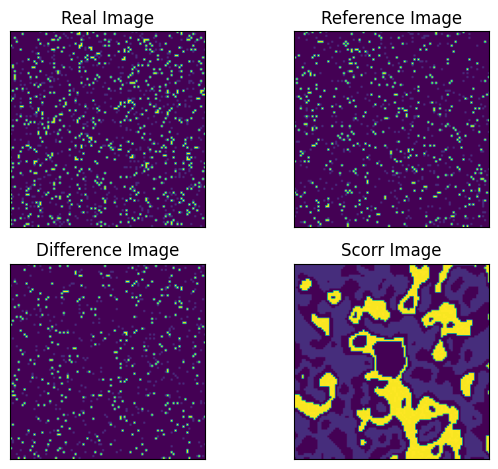

Bogus


In [5]:
get_example_images(512)
print(dataset1.label[512])

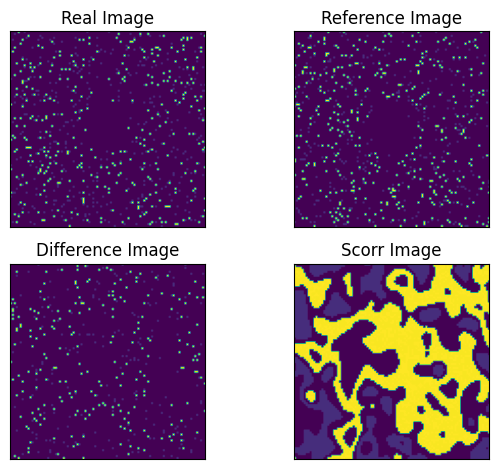

Real


In [6]:
get_example_images(560)
print(dataset1.label[560])

In [7]:
PERSONA = ["""<PERSONA>
You are an experienced astrophysicist and your task is to classify the given set of 4 images is real or bogus. You have seen thousands of images during your life time and you are very good at making this classification by look at the images and following the instructions. 
</PERSONA>"""]
INSTRUCTIONS = ["""\n<INSTRUCTIONS>
**1. Purpose**
This is meant as a visual guide to vetting MeerLICHT/BlackGEM data for the Real/Bogus classification. At this stage we are trying to get a high-fidelity machine learning network of what is real and what is bogus. As such it is not necessary to further classify what type of real or what type of bogus it is. But what is real and what is bogus?

**2. Real: Any source that is of astrophysical origin, and variable in time and/or position.**
A real source therefore:
a) has a shape that reflects a **point-source**. Most MeerLICHT data is taken in decent focus conditions, so for us it means that the source is **round**, and has a (visual) extent of ~5-10 pixels. Because conditions vary this number also varies, also between the new and the reference image.
b) is **positive** in either the new or the reference image.
c) can be **variable** in both directions, e.g. fading or brightening between the new and reference image, and is therefore positive or negative in the difference image and the Scorr image.
d) can **(dis)appear** between the new and the reference image. This means that in one of the two images there is no source at all, and in the other there is a clear point-source. Note that this can happen on top of an underlying galaxy.
*e) Looks like an object with a stellar PSF in the Scorr image, i.e. not just a single bright pixel in the center.*

What is the difference between a transient and a variable?
This is a long-standing and fluid debate. For the moment we will adopt the following distinction:
a) a **transient** is an object **with no underlying quiescent point-source counterpart** in the reference image.
b) a **variable** is an object with **an underlying quiescent point-source counterpart** in the reference image.
This is a phenomenological distinction based solely on our own data, not an astrophysical distinction.
E.g. we would all consider a supernova to be a transient (i.e. a destructive, non-repeating, once-off
event). However, in deep images it may have an underlying counterpart (the original star). Or it was
detected while bright in the reference image and therefore all the new images shows it to be fading, i.e.
a variable.
On the other hand, we can have a dwarf nova outburst occuring in a Cataclysmic Variable with a
counterpart that is below our detection limit. Eventhough astrophysically most people would classify a
dwarf nova outburst as a variable (i.e. a non-destructive, repeating event), in our data it will look like a
transient.
Without any additional information (light curves, deeper images, spectra) we will not be able to make a
distinction between these. However, for our real-bogus classification this doesn’t matter. Both are **real**."

**3. Bogus: Any source that is not of astrophysical origin**
Bogus sources are those that are not of astrophysical origin but artefacts, caused by the detector, cosmic-rays, reflections, or the data processing.
A bogus source therefore generally has:
a) a shape that is **not a point-source**: not round, not ‘Gaussian’, with a size ≾5 pixels or ≿10 pixels. Note that a ‘point’ (i.e. one bright pixel), is not a point-source, *also in the Scorr image*
b) is **negative** in either the new or the reference image. Any real source needs to show a positive image, i.e. countrates higher than the background sky.

**4. Information provided**
All vetters will be shown four images that are cut-outs of the science images around the suspected source. Therefore it is important to note that **the candidate transient lies in the center of the cut-outs**. Use the full 100x100 pixel image to base your judgement on. If you see that the transient candidate has a very different psf than other stars in the image; or if the image is extended and very close to the edge (possibly a reflection): use this information in your judgement.

The four images are:
1) The **new** image, i.e. the latest science image. This is fully reduced, i.e. debiased and flatfielded.
2) The **reference** image, against which the new image is compared. For the moment the reference images are simply the first image that was taken of a field. The depth and image quality of the reference image therefore does not have to be better/deeper than that of the new image. 
3) The **difference** image. This is the image that is the residual after the new and reference image are  subtracted from each other after being sky-subtracted and scaled/convolved to have matching point- spread-functions. Variations in sky background and seeing should therefore not show up in the difference image. Reals should show up as a point-source object with either positive or negative flux. Residuals due to an imperfect astrometric regridding can still show up. These will generally be seen as ‘ying-yang’ patterns of positive/negative flux. 
4) The **Scorr** image: this is the significance image, which is constructed based on the difference image, but with an additional noise model taken into account to calculate significances. For the moment it takes Poisson noise and astrometric jitter into account. The ‘ying-yang’ patterns from the difference images should therefore disappear as they are mostly due to astrometric jitter. The Scorr image also has each point in the difference image convolved with the local psf. For this reason the Scorr image looks much more ‘smoothed’ than the Difference image. The pixel values in the Scorr image give the significance of a transient being centered on that pixel. It is based on this value of the central pixel of a ‘source’ in the Scorr image that the object was picked as a candidate transient (e.g. Scorr_i,j > 6, or Scorr_i,j > 12, etc., depending on the exact criterium used). 
</INSTRUCTIONS>

"""]

In [8]:
# Report 3 Real and 3 Bogus examples for the prompt
EXAMPLES = ["<EXAMPLES>\n"]
for i in range(len(sample_indexes)):
    
    str_EX = f"""Example {i+1}:
    """
    all_list = create_ex(sample_indexes[i])
    all_list.insert(0, str_EX)
    all_list.append(dataset1.label[sample_indexes[i]]),
    for k in all_list:
        EXAMPLES.append(k)
EXAMPLES.append("\n</EXAMPLES>\n")
TASK = ["""<TASK>
Your task is to read the INSTRUCTIONS and look at the 4 images, classify these 4 images to be Real or Bogus. Provide your thought process to explain how you reasoned to provide the response.
</TASK>\n
"""]

In [17]:
stat_prompt = []
stat_prompt.extend(PERSONA + INSTRUCTIONS + EXAMPLES + TASK) 

for t in [8,59,324,999]:
    print("Ground truth for the observation ", t, " is ", dataset1.label[t], "\n")
    dyna_prompt = create_ex(t)
    generate(stat_prompt + dyna_prompt)

Ground truth for the observation  8  is  Real 

Bogus. 

There is no clear point source in the new or reference images. The Scorr image shows a diffuse shape rather than a point-source.  The images appear to be dominated by noise. 
Ground truth for the observation  59  is  Real 

Real. 

The difference image shows a clear positive signal. Moreover, the Scorr image shows a point-source object with stellar PSF. Therefore, it is classified as Real. Ground truth for the observation  324  is  Real 

Label: Bogus

Reason:There is no clear point source in the new, reference or difference images. Although the Scorr image appears to show a source, it is not shaped like other stellar objects in the image. Therefore, this is likely a false positive. 
Ground truth for the observation  999  is  Bogus 

Real.

The source has a point-source shape that is round and positive in the new image. There is no obvious counterpart in the reference image. The difference and Scorr images also show a clear point

In [11]:
dataset1.label[[8,59,324,999]]

8       Real
59      Real
324     Real
999    Bogus
Name: label, dtype: object

In [10]:
# # APPENDIX
# def read_png_examples_to_base64(directory):
#   """
#   Reads all the PNG files in the directory and returns their contents in base64 format in a list.

#   Args:
#     directory: The path to the folder that contains the PNG files.

#   Returns:
#     A list with base64-encoded PNG data for each picture.
#   """

#   filenames = []
#   im_array = []
#   for filename in os.listdir(directory):
#     if os.path.isfile(os.path.join(directory, filename)):
#       filenames.append(os.path.join(directory, filename))
#   filenames.sort()
  

#   for files in filenames:
#     with open(files, "rb") as f:
#       png_data = f.read()
#       im_array.append(base64.b64encode(png_data).decode("utf-8"))

#   return im_array

# im_arrays = read_png_examples_to_base64("./docs/img/")

# REAL_ EXAMPLES_EXP = """All images show the object in the sequence: New, Reference, Difference, Scorr. In all examples the central source was detected with an |Scorr| >12. All images are 100x100 pixels (~ 1 ́ x 1 ́)"""

# R_EX1 = f"""
# EXAMPLE_1:
# The **new** image: {im_array[0]}
# The **reference** image: {im_array[1]}
# The **difference** image: {im_array[2]}
# The **Scorr** image: {im_array[3]}
# ANALYSIS: the new image shows a point-source-like positive object not present in the reference image. The Difference and Scorr images show a positive residual of stellar shape.
# CLASSIFICITION: **REAL**
# """
# R_EX2 = f"""
# EXAMPLE_2:
# The **new** image: {im_array[4]}
# The **reference** image: {im_array[5]}
# The **difference** image: {im_array[6]}
# The **Scorr** image: {im_array[7]}
# ANALYSIS: the new image shows a point-source that has faded with respect to its level in the reference image. This leaves a negative point-source-like residual in the Difference and Scorr images 
# CLASSIFICITION: **REAL**
# """
# R_EX3 = f"""
# EXAMPLE_3:
# The **new** image: {im_array[8]}
# The **reference** image: {im_array[9]}
# The **difference** image: {im_array[10]}
# The **Scorr** image: {im_array[11]}
# ANALYSIS: the new image shows a point-source that has brightened with respect to the level in the reference image. This leaves a positive point-source-like residual in the Difference and Scorr images. Note the 'ying-yang’ pattern in the bright star on the left which is present in the Difference image, but that is (almost) completely gone in the Scorr image.
# CLASSIFICITION: **REAL**
# """
# R_EX4 = f"""
# EXAMPLE_4:
# The **new** image: {im_array[12]}
# The **reference** image: {im_array[13]}
# The **difference** image: {im_array[14]}
# The **Scorr** image: {im_array[15]}
# ANALYSIS: This is a faint source, point-like, that has appeared in the new image, without any source being present in the difference image. It is also a point source in both the Difference and Scorr images.
# CLASSIFICITION: **REAL**
# """
# R_EX5 = f"""
# EXAMPLE_5:
# The **new** image: {im_array[16]}
# The **reference** image: {im_array[17]}
# The **difference** image: {im_array[18]}
# The **Scorr** image: {im_array[19]}
# ANALYSIS: the new image shows a point-source-like positive object not present in the reference image. The Difference and Scorr images show a positive residual of stellar shape.
# CLASSIFICITION: **REAL**
# """
# R_EX1 = f"""
# EXAMPLE_1:
# The **new** image: {im_array[0]}
# The **reference** image: {im_array[1]}
# The **difference** image: {im_array[2]}
# The **Scorr** image: {im_array[3]}
# ANALYSIS: the new image shows a point-source-like positive object not present in the reference image. The Difference and Scorr images show a positive residual of stellar shape.
# CLASSIFICITION: **REAL**
# """
# R_EX1 = f"""
# EXAMPLE_1:
# The **new** image: {im_array[0]}
# The **reference** image: {im_array[1]}
# The **difference** image: {im_array[2]}
# The **Scorr** image: {im_array[3]}
# ANALYSIS: the new image shows a point-source-like positive object not present in the reference image. The Difference and Scorr images show a positive residual of stellar shape.
# CLASSIFICITION: **REAL**
# """
# R_EX1 = f"""
# EXAMPLE_1:
# The **new** image: {im_array[0]}
# The **reference** image: {im_array[1]}
# The **difference** image: {im_array[2]}
# The **Scorr** image: {im_array[3]}
# ANALYSIS: the new image shows a point-source-like positive object not present in the reference image. The Difference and Scorr images show a positive residual of stellar shape.
# CLASSIFICITION: **REAL**
# """
# R_EX1 = f"""
# EXAMPLE_1:
# The **new** image: {im_array[0]}
# The **reference** image: {im_array[1]}
# The **difference** image: {im_array[2]}
# The **Scorr** image: {im_array[3]}
# ANALYSIS: the new image shows a point-source-like positive object not present in the reference image. The Difference and Scorr images show a positive residual of stellar shape.
# CLASSIFICITION: **REAL**
# """
# R_EX1 = f"""
# EXAMPLE_1:
# The **new** image: {im_array[0]}
# The **reference** image: {im_array[1]}
# The **difference** image: {im_array[2]}
# The **Scorr** image: {im_array[3]}
# ANALYSIS: the new image shows a point-source-like positive object not present in the reference image. The Difference and Scorr images show a positive residual of stellar shape.
# CLASSIFICITION: **REAL**
# """
